# Person of Interest Identification - Enron
## Udacity - Introduction to Machine Learning
### Wesley Scoggin
**Purpose:** To Identify persons of interest (POI) utilizing machine learning techniques to evaluate email data published as part of the fraud investigation of Enron business practices in the early 2000's


In [2]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)
import sys
import math
sys.path.append("../tools/")
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tester import dump_classifier_and_data, test_classifier
from feature_format import featureFormat, targetFeatureSplit

Toggle code

### Available Data
In this financial information dataset of Enron employees there are 146 entries with 21 features each, including POI. The email address feature is neither indicator of dimension or categorical and will be removed in feature selection.


In [3]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

available_features=[]

for people, k in data_dict.iteritems():
    for key, value in k.iteritems():
        if key not in available_features:
            available_features.append(key)
print 'Number of employees in dataset:', len(data_dict),'\n'
print 'Number of Features in dataset:',len(available_features)\
,'\ncomprised of:\n', available_features,'\n'

print 'POI''s: ', sum([1 for p in data_dict if data_dict[p]['poi']==True]), \
'NonPOI''s:', sum([1 for p in data_dict if data_dict[p]['poi']==False]), '\n'

def count_unique_and_null(dictionary):
    feature_summary = []
    for feature in [f for f in available_features if f!='poi']:
        entry_unique= []
        nan_count = 0
        for entry in dictionary:
            if dictionary[entry][feature] == 'NaN':
                nan_count += 1
            elif dictionary[entry][feature] not in entry_unique and dictionary[entry][feature] !='NaN' :
                entry_unique.append(entry)
        feature_summary.append({'feature':feature
                                ,'unique count':len(entry_unique)
                                ,'nans': nan_count})
    return feature_summary

df = pd.DataFrame(count_unique_and_null(data_dict))
print 'NaN / Unique Values'
print df.sort_values(by = 'nans', ascending = False)



Number of employees in dataset: 146 

Number of Features in dataset: 21 
comprised of:
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person'] 

POIs:  18 NonPOIs: 128 

NaN / Unique Values
                      feature  nans  unique count
11              loan_advances   142             4
15              director_fees   129            17
8   restricted_stock_deferred   128            18
2           deferral_payments   107            39
16            deferred_income    97            49
17        long_term_incentive    80            66
5                       bonus    64            82
19    from_poi_to_this_person    60            86
7     shared_receipt_with_

### Outliers
As detailed below, Eugene Lockhart, seems to have 'Nan' as values for each feature type. Further visual inspection below of the keys of each feature list indicates that there are two other employees in this list that do not seem to have names that are consistent with the format: LASTNAME FIRSTNAME MI and will be removed from the dataset.

In [4]:
#Identify and Remove outliers

#find employees with nan for all data
all_nan = []
for person, features in data_dict.items():
    notNaN = False
    for feature, val in features.items():
        if feature != 'poi':
            if val != 'NaN':
                notNaN = True
                break
    if not notNaN:
        all_nan.append(person)
print 'Users with all ''NaN'' data', all_nan


Users with all NaN data ['LOCKHART EUGENE E']


In [5]:
#Examine people in the data_dict to find names that do not resemble employees:
people = sorted(list(data_dict.keys()))
c1 = pd.Series(people[0:30])
c2 = pd.Series(people[30:60])
c3 = pd.Series(people[60:90])
c4 = pd.Series(people[90:120])
c5 = pd.Series(people[120:])
columns = pd.DataFrame({' ':c1, '  ':c2, '   ':c3, '    ':c4, '     ':c5})
#format nan values for printing list columnwise to display
columns = columns.replace(np.nan, '', regex=True)
#highlight suspicious entries that do not resemble employee names 
#or employees with all NaN data
def highlight_vals(val, color='green'):
    if val in ['TOTAL','THE TRAVEL AGENCY IN THE PARK','LOCKHART EUGENE E']:
        return 'background-color: %s' % color
    else:
        return ''
columns.style.applymap(highlight_vals, subset=[' ', '  ', '   ','    ', '     '])

,,,,,
0,ALLEN PHILLIP K,DEFFNER JOSEPH M,HAUG DAVID L,MCDONALD REBECCA,SHERRICK JEFFREY B
1,BADUM JAMES P,DELAINEY DAVID W,HAYES ROBERT E,MCMAHON JEFFREY,SHERRIFF JOHN R
2,BANNANTINE JAMES M,DERRICK JR. JAMES V,HAYSLETT RODERICK J,MENDELSOHN JOHN,SKILLING JEFFREY K
3,BAXTER JOHN C,DETMERING TIMOTHY J,HERMANN ROBERT J,METTS MARK,STABLER FRANK
4,BAY FRANKLIN R,DIETRICH JANET R,HICKERSON GARY J,MEYER JEROME J,SULLIVAN-SHAKLOVITZ COLLEEN
5,BAZELIDES PHILIP J,DIMICHELE RICHARD G,HIRKO JOSEPH,MEYER ROCKFORD G,SUNDE MARTIN
6,BECK SALLY W,DODSON KEITH,HORTON STANLEY C,MORAN MICHAEL P,TAYLOR MITCHELL S
7,BELDEN TIMOTHY N,DONAHUE JR JEFFREY M,HUGHES JAMES A,MORDAUNT KRISTINA M,THE TRAVEL AGENCY IN THE PARK
8,BELFER ROBERT,DUNCAN JOHN H,HUMPHREY GENE E,MULLER MARK S,THORN TERENCE H
9,BERBERIAN DAVID,DURAN WILLIAM D,IZZO LAWRENCE L,MURRAY JULIA H,TILNEY ELIZABETH A


In [6]:
#Remove people identified above
for person in ['TOTAL','THE TRAVEL AGENCY IN THE PARK','LOCKHART EUGENE E']:
    data_dict.pop(person)


### Creating New Features
As the chart of nans indicates above a high percentage of 'loan_advances', 'director_fees', 'restricted_stock_deferred', 'deferral_payments', and 'deferred_income' are null. I will remove these from consideration and limit analysis to the remaining features, with the exception of email. As discussed, email_address is neither categorical or numerically indictative of information that should be useful in any capacity to this investigation unless it was needed as a unique identifier for each employee in the event we were not provided with a name key.

In an effort to provide some perspective I will add two features that should help normalize communication between a person in the data set and a person of interest. Ratios of email from a poi / to a poi and the total emails sent and recieved will be created. Interestingly, all of Gene Humphrey's sent emails are to POI's. 

In [7]:
def computeRatio( poi_messages, all_messages ):
    if not math.isnan(float(poi_messages)) and not math.isnan(float(all_messages)):
        fraction = round(float(poi_messages)/float(all_messages),3)
    else:
        fraction =0
    return fraction

for person in data_dict:
    from_poi = data_dict[person]['from_poi_to_this_person']
    total_inbox = data_dict[person]['to_messages']
    to_poi = data_dict[person]['from_this_person_to_poi']
    total_outbox = data_dict[person]['from_messages']
    
    data_dict[person]['ratio_from_poi'] = computeRatio( from_poi, total_inbox )
    data_dict[person]['ratio_to_poi']  = computeRatio( to_poi, total_outbox )

features_list = [ 'poi','salary','to_messages','total_payments','exercised_stock_options'
                 ,'bonus','restricted_stock','shared_receipt_with_poi','total_stock_value'
                 ,'expenses','from_messages','other','from_this_person_to_poi'
                 ,'long_term_incentive','from_poi_to_this_person','ratio_from_poi'
                 ,'ratio_to_poi']

my_dataset = data_dict

# ### Extract features and labels from dataset for local testing
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

max to poi ratio:  1.0
max from poi ratio:  0.217
Person with 100% emails sent to POI ['HUMPHREY GENE E']


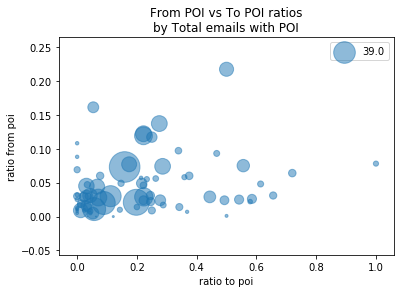

In [8]:
print 'max to poi ratio: ', max([data_dict[p]['ratio_to_poi'] for p in data_dict])
print 'max from poi ratio: ', max([data_dict[p]['ratio_from_poi'] for p in data_dict])
print 'Person with 100% emails sent to POI',[p for p in data_dict if data_dict[p]['ratio_to_poi']==1.]

ratiosdf = pd.DataFrame(data)
ratiosdf.columns = features_list

plt.scatter(ratiosdf.ratio_to_poi, ratiosdf.ratio_from_poi
            , s=ratiosdf.from_this_person_to_poi+ratiosdf.from_poi_to_this_person
            , alpha=0.5)

plt.legend(ratiosdf.from_this_person_to_poi+ratiosdf.from_poi_to_this_person)
plt.title('From POI vs To POI ratios\nby Total emails with POI')
plt.xlabel('ratio to poi')
plt.ylabel('ratio from poi')
plt.show()

### Selecting features with Select K Best
Select K Best will be utilized below to limit the number of features evaluated in various algorithms. Scores for each feature will indicate which features contribute the most to an evaluation of POI.

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

kbest = SelectKBest(k = 13)
gaus = GaussianNB()
pipeline = Pipeline(steps = [('kbest', kbest), ('gaus', gaus)])
pipeline.fit(features, labels)

#Get Index for kbest
kbest_index = kbest.get_support(indices = True)

#add scores to dictionary with feature names as keys
scores = {}
for i in kbest_index:
    scores[features_list[i + 1]] = round(kbest.scores_[i],2)

#print ordered scores
selected_features = scores.keys()
selected_features.insert(0, 'poi')
pd.Series(scores).sort_values(ascending = False)

exercised_stock_options    24.82
total_stock_value          24.18
bonus                      20.79
salary                     18.29
ratio_to_poi               16.41
long_term_incentive         9.92
restricted_stock            9.21
total_payments              8.77
shared_receipt_with_poi     8.59
expenses                    6.09
from_poi_to_this_person     5.24
other                       4.19
ratio_from_poi              3.15
dtype: float64

Feature scaling will not be implemented since I will not be performing PCA, the algorithms evaluated below, including decition trees, random forrest, and naive bayes wouldn't benifit from PCA anyway since each evaluates features individually. For Logistic regression, tuning with the C and penalty parameters can mitigate feature regularization.

### Algorithm Selection and Evaluation

In [10]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

my_data = featureFormat(data_dict, selected_features)
labels, features = targetFeatureSplit(my_data)
#Create testing and training folds for more homogenous training and test datasets
cv = StratifiedShuffleSplit(labels, 2000, random_state = 42)
for train_idx, test_idx in cv: 
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )
def modelScoring(pred, test_labels):
    accuracy = accuracy_score(pred, test_labels)
    precision = precision_score(pred, test_labels)
    recall = recall_score(pred, test_labels)
    f1 = f1_score(pred, test_labels)
    confusion = confusion_matrix(pred, test_labels)
    
    scores = {'Accuracy': accuracy
              ,'Precision': precision 
              ,'Recall': recall 
              ,'F_Score': f1
              ,'Num of Predictions':len(test_labels)
              ,'True positives': confusion[1,1]
              ,'True negatives': confusion[0,0]
              ,'False positives': confusion[0,1]
              ,'False negatives': confusion[1,0]
              }
    return scores

def finalScores(scores):
    cols = ['Accuracy','Precision','Recall','F_Score','Num of Predictions','True positives','False positives','False negatives','True negatives']
    final_scores = pd.DataFrame(scores,cols).transpose()
    final_scores = final_scores.sort_values('F_Score',ascending=False)
    return final_scores

In [11]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit(features_train,labels_train)
pred_nb = clf_nb.predict(features_test)
nb_scores = modelScoring(pred_nb, labels_test)

In [12]:
#Dtree
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
clf_dt.fit(features_train,labels_train)
pred_dt = clf_dt.predict(features_test)
dt_scores = modelScoring(pred_dt, labels_test)

In [13]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_lr= LogisticRegression()
clf_lr.fit(features_train,labels_train)
pred_lr = clf_lr.predict(features_test)
lr_scores = modelScoring(pred_lr, labels_test)

In [14]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
clf_rfc.fit(features_train, labels_train)
pred_rfc = clf_rfc.predict(features_test)
rfc_scores = modelScoring(pred_rfc, labels_test)

In [309]:
scores = {'Naive Bayes': nb_scores
           ,'Decision Tree': dt_scores
           ,'Logistic Reg': lr_scores
           ,'Random Forest': rfc_scores}
finalScores(scores)

,Accuracy,Precision,Recall,F_Score,Num of Predictions,True positives,False positives,False negatives,True negatives
Random Forest,1.000000,1.0,1.000000,1.00,15.0,2.0,0.0,0.0,13.0
Naive Bayes,0.866667,0.5,0.500000,0.50,15.0,1.0,1.0,1.0,12.0
Logistic Reg,0.600000,0.5,0.166667,0.25,15.0,1.0,1.0,5.0,8.0
Decision Tree,0.800000,0.0,0.000000,0.00,15.0,0.0,2.0,1.0,12.0


Logistic regression seems to be the algorithm with the best parameters for tuning in this case. It also happens to have parameters that will mitigate feature scaling issues. It also seems to be slightly worse than Naive Bayes in recall. Random Forest appears to be overfit with no parameters set. 
I will tune Logistic regression to see if I can enhance its performance.

### Algorithm Tuning

Parameters in machine learning algorithms can change how the behavior handles the features. Tuning refers to either manually, or programatically changing these parameters to enhance prediction performance. Untuned algorithms can provide some insite into data but should never be the end of the investigation. 

For Logistic Regression I will be tuning with the following parameters:
    
- max_iter: limits the number of iterations before each solver converges
    
- penalty: specifies the norm used in penalization with solvers 
    
- C: represents the inverse of regularization strength. smaller values specify stronger regularization

In [21]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(n_jobs = -1)
parameters = {'max_iter':range(20, 150, 10)
              ,'penalty' : ('l1', 'l2')
              ,'C': (.1,.2,.3) 
              #,.4,.5,.6,.7,.8,.9,1.) these values were also tested but .2 was selected 
             }
lr_grid = GridSearchCV(lr, parameters, n_jobs = -1)
lr_grid.fit(features_train, labels_train)

pred_lr_grid = lr_grid.predict(features_test)
logistic_reg_tuned = modelScoring(pred_lr_grid, labels_test)

print "Selected Parameters:", lr_grid.best_params_

Selected Parameters: {'penalty': 'l1', 'C': 0.2, 'max_iter': 30}


In [19]:
final_scores = {'Logistic Reg Tuned': logistic_reg_tuned
           ,'Logistic Reg Untuned': lr_scores
         }
finalScores(final_scores)

,Accuracy,Precision,Recall,F_Score,Num of Predictions,True positives,False positives,False negatives,True negatives
Logistic Reg Tuned,0.933333,0.5,1.000000,0.666667,15.0,1.0,1.0,0.0,13.0
Logistic Reg Untuned,0.600000,0.5,0.166667,0.250000,15.0,1.0,1.0,5.0,8.0


### Evaluation and Validation
By splitting the data set into training and testing data we prevent overtuning an algorithm to the point that it has perfect prediction capablity on the existing data. This may seem like a success during testing but if that algorithm were put into practical use it would be very hard to validate that could generalize new data. 

Using StatifiedShuffleSplit we can fold limited datasets to emulate larger datasets. Although this strategy wouldn't be as benificial as having a larger dataset, it does provide an advantage over splitting the data proportionally. It also maintains the ratio between classes for each fold as the original data set providing an advantage of manually folding the data set with random slices.

In conclusion, by tuning the Logistic Regression algorithm I was able to enhance accuracy, precision, recall and F score. The tuned algorithm's precision was %50, detailed by the true and false positives. It successfully predicted a POI that was actually a POI so the recall was %100 but over predicted someone that hadn't been identified as a POI. In this case of investigating possible POI's in the Enron Data, over predicting may actually be desireable, since it would only open that person to further investigation.

Further investigation into actual email content may provide better insight into POI identification. The imbalance between identified persons of interest and non POI's may in the financial and email count data more unreliable than it should be.

In [20]:
## Dump your classifier, dataset, and features_list so anyone can
## check your results. You do not need to change anything below, but make sure
## that the version of poi_id.py that you submit can be run on its own and
## generates the necessary .pkl files for validating your results.
clf = lr_grid
dump_classifier_and_data(clf, my_dataset, features_list)